# **Manulife: Stock Market Forecasting using Time Series Analysis**

In [ ]:
!pip install pmdarima

In [51]:
import requests
import json
import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [52]:
import warnings
warnings.filterwarnings("ignore")

## **Step 1: Data Acquisition via API**
Extract daily adjusted stock price from 2023-01-01 to 2025-02-21


In [53]:
API = 'https://api.polygon.io/v2/aggs/ticker/MFC/range/1/day/2023-01-01/2025-02-21?adjusted=true&sort=asc&apiKey=C1BeQwt48HpHkn5gVvkVvzC0ZugsamPo'

In [54]:
r = requests.get(API)
if r.reason == 'OK':
  results = r.json()['results']

In [55]:
dates = []
prices = []
for result in results:
  dates.append(datetime.datetime.fromtimestamp(result['t'] / 1000))
  prices.append(result['c'])

In [90]:
df = pd.DataFrame({'Date': dates, 'Price': prices})
df.set_index('Date', inplace=True)
df

,Price
Date,
2023-03-13 04:00:00,18.45
2023-03-14 04:00:00,18.80
2023-03-15 04:00:00,18.08
2023-03-16 04:00:00,18.01
2023-03-17 04:00:00,17.53
...,...
2025-02-14 05:00:00,29.69
2025-02-18 05:00:00,30.01
2025-02-19 05:00:00,29.78


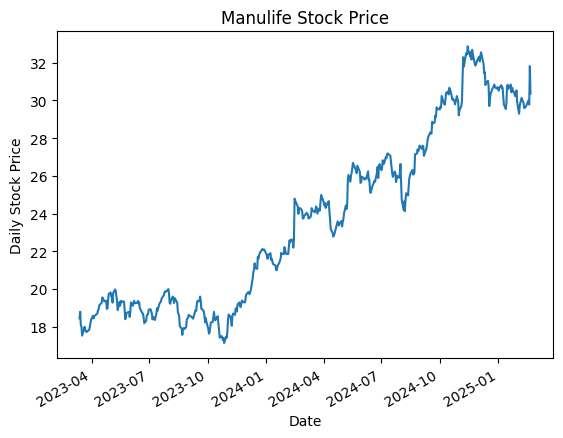

In [91]:
plt.plot(dates, prices)
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Daily Stock Price')
plt.title('Manulife Stock Price')
plt.show()

Text(0.5, 1.0, 'Manulife Stock Price Distribution')

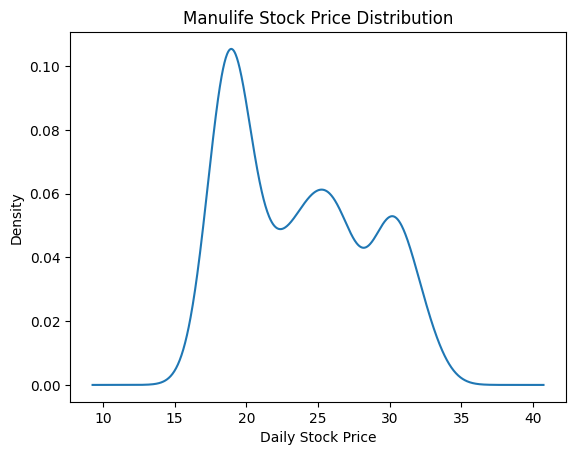

In [92]:
df['Price'].plot(kind='kde')
plt.xlabel('Daily Stock Price')
plt.title('Manulife Stock Price Distribution')

## **Step 2: Data Preprocessing**

**Test for Stationarity:** A stationarity in a time series means that its mean and variance do not change over time.

In [93]:
def test_stationarity(prices):
    #Determing rolling statistics
    rolmean = prices.rolling(12).mean()
    rolstd = prices.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(prices, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    adft = adfuller(prices,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

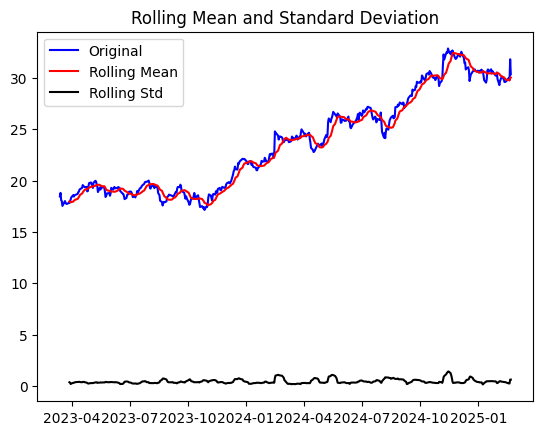

Test Statistics                 -0.508172
p-value                          0.890412
No. of lags used                 0.000000
Number of observations used    488.000000
critical value (1%)             -3.443821
critical value (5%)             -2.867481
critical value (10%)            -2.569934
dtype: float64


In [96]:
test_stationarity(df['Price'])

**Eliminate Trend** \\
Log Transformation: Stock prices have increasing variance over time

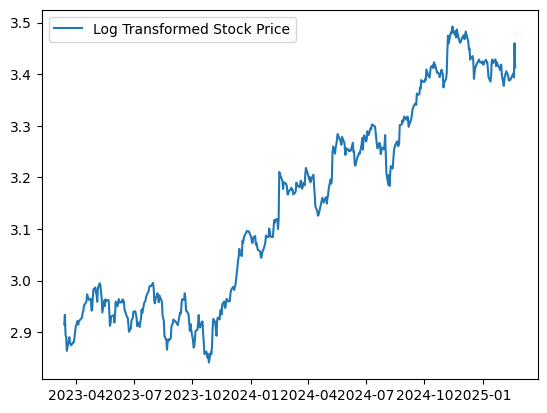

In [97]:
df_log = np.log(df)
plt.plot(df_log, label="Log Transformed Stock Price")
plt.legend()
plt.show()

Calculate the rolling average of the series after obtaining the log of the series.

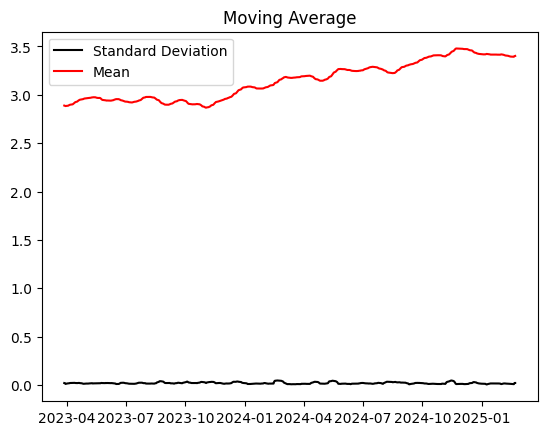

In [98]:
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

**Train Test Split**

In [99]:
# training set: from 2023-01-01 to 2024-12-31
index = dates.index(datetime.datetime(2024, 12, 31, 5, 0))
train = df_log.iloc[:index + 1]
# test set: from 2025-01-02 to 2025-2-21
test = df_log.iloc[index + 1:]

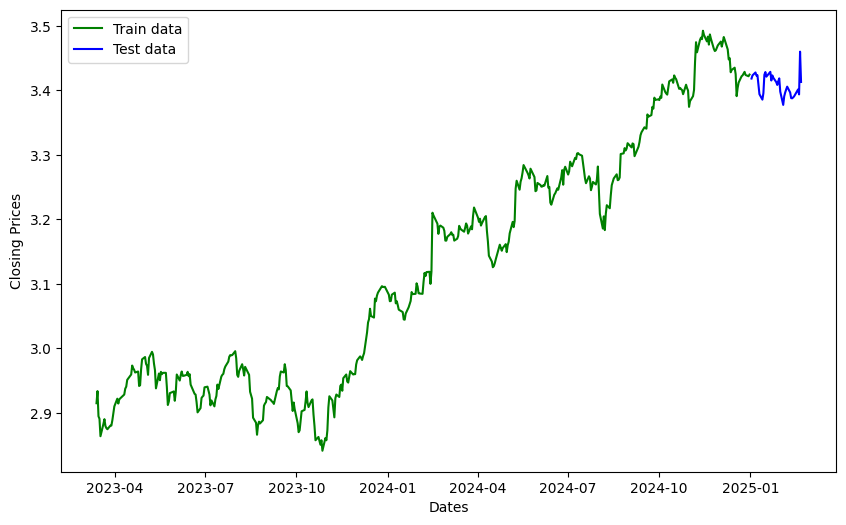

In [100]:
plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train, 'green', label='Train data')
plt.plot(test, 'blue', label='Test data')
plt.legend()

## **Step 3: ARIMA Model Fitting**
choose the ARIMA model p,d, q parameters \\
- p: the number of lag observations included in the model, reflecting the autoregressive part that predicts future values based on past values.
- d: the degree of differencing required to make the data stationary, addressing trends or seasonal effects by subtracting previous observations from current ones.
- q: the size of the moving average window, which incorporates the dependency of an observation on a residual error from a moving average model applied to lagged observations.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2643.451, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2645.169, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2645.782, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2642.135, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2644.132, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2645.817, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2643.542, Time=1.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2643.969, Time=0.56 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2641.791, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2644.437, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 3.486 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  455
Model:               SARIMAX(0, 1, 2)   Log Likeliho

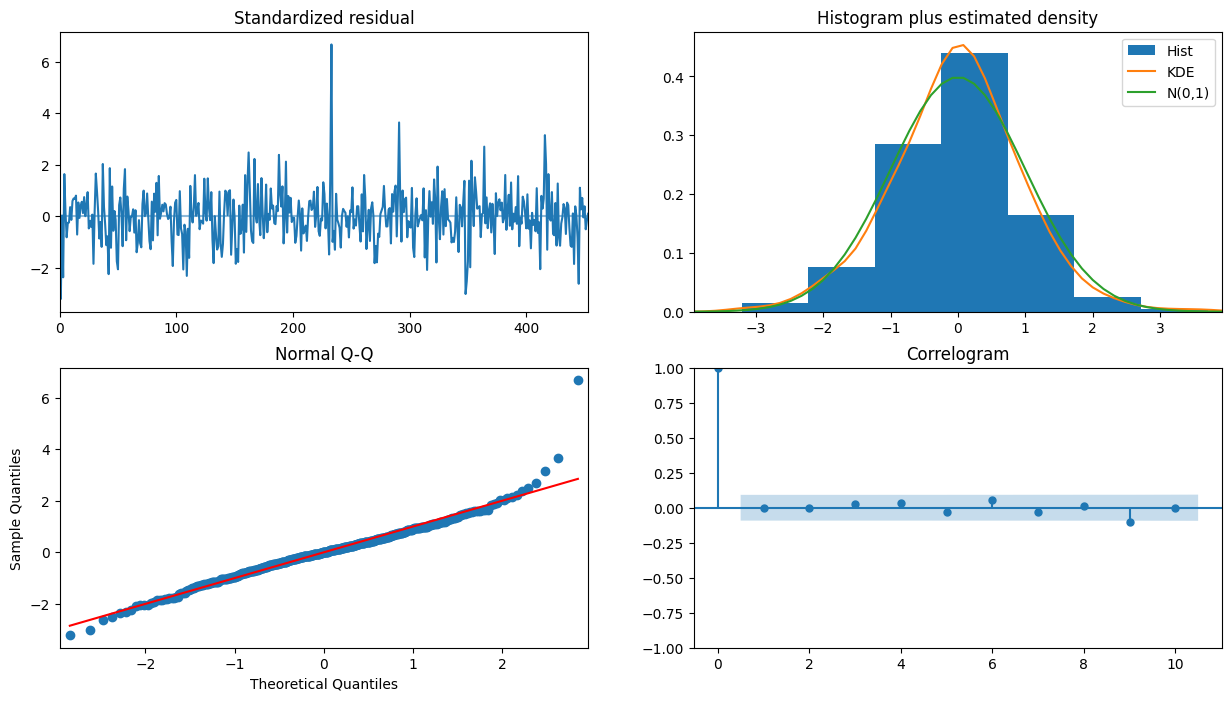

In [101]:
model = auto_arima(train, start_p=0, start_q=0,
                   test='adf',       # use adftest to find optimal 'd'
                   max_p=4, max_q=4,
                   m=1,
                   d=None,           # let model determine 'd'
                   seasonal=False,
                   start_P=0,
                   D=0,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
print(model.summary())
model.plot_diagnostics(figsize=(15,8))
plt.show()

- Top left: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.
- Top Right: normal distribution with a mean of around zero.
- Bottom left: Normal Distribution
- Bottom Right: The residual errors are not autocorrelated

## **Step 4: Forecasting**
ARIMA(0, 1, 2)

Rolling Forecast with 95% Confidence Interval

In [102]:
history = list(train["Price"])
predictions = []
lower_bounds = []
upper_bounds = []

In [103]:
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()

    forecast_obj = model_fit.get_forecast(steps=1)
    forecast = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int(alpha=0.05)

    predictions.append(forecast[0])
    lower_bounds.append(conf_int[0, 0])
    upper_bounds.append(conf_int[0, 1])

    history.append(test["Price"].iloc[t])

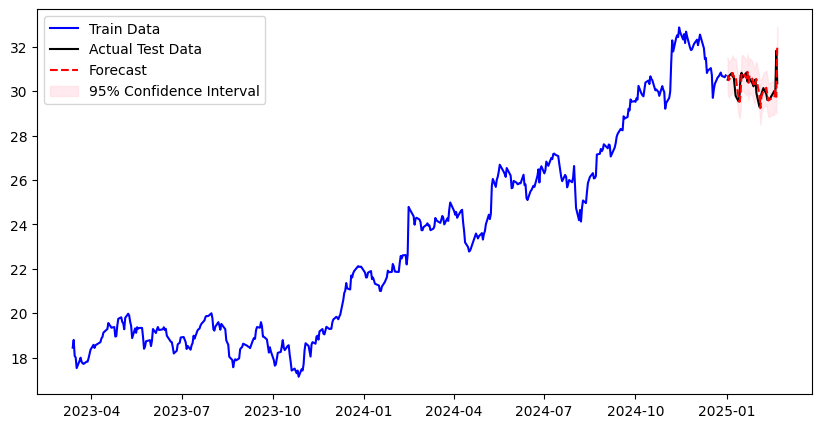

In [104]:
test_index = test.index
plt.figure(figsize=(10,5))
plt.plot(train.index, np.exp(train["Price"]), label="Train Data", color="blue")
plt.plot(test_index, np.exp(test["Price"]), label="Actual Test Data", color="black")
plt.plot(test_index, np.exp(predictions), label="Forecast", color="red", linestyle="dashed")
plt.fill_between(test_index, np.exp(lower_bounds), np.exp(upper_bounds), color="pink",
                 alpha=0.3, label="95% Confidence Interval")
plt.legend()
plt.show()

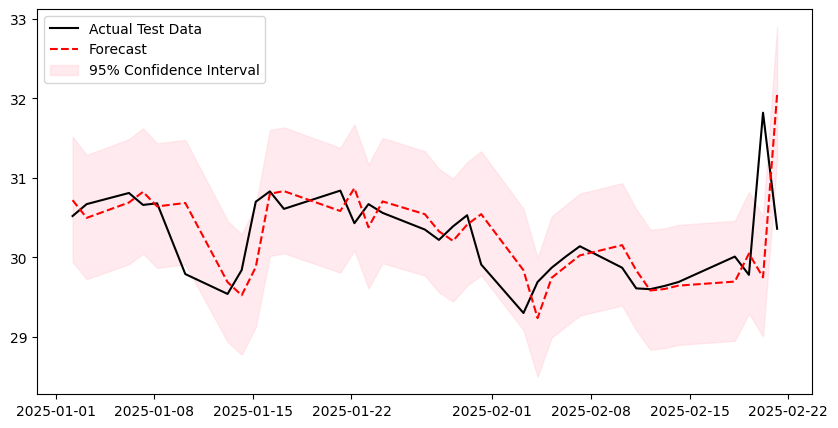

In [105]:
test_index = test.index
plt.figure(figsize=(10,5))
plt.plot(test_index, np.exp(test["Price"]), label="Actual Test Data", color="black")
plt.plot(test_index, np.exp(predictions), label="Forecast", color="red", linestyle="dashed")
plt.fill_between(test_index, np.exp(lower_bounds), np.exp(upper_bounds), color="pink",
                 alpha=0.3, label="95% Confidence Interval")
plt.legend()
plt.show()

In [106]:
mae = mean_absolute_error(np.exp(test["Price"]), np.exp(predictions))
mse = mean_squared_error(np.exp(test["Price"]), np.exp(predictions))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

Mean Absolute Error (MAE): 0.3476190480363486
Mean Squared Error (MSE): 0.312843712250921


## **Step 6: Deliver the model using the lastest data**


In [112]:
def model_delivery():

  results = get_latest_data()
  if results:
    new_df = update_table(results)
  else:
    new_df = df_log

  prediction, lower_bound, upper_bound = generate_forceast(new_df)
  next_day = datetime.date.today() + datetime.timedelta(days=1)
  date_string = next_day.strftime("%Y-%m-%d")

  return f'On {date_string}, the predicted stock price for Manulife is US${prediction:.2f}, with a lower bound of US${lower_bound:.2f} and an upper bound of US${upper_bound:.2f}.'

print(model_delivery())

On 2025-03-12, the predicted stock price for Manulife is US$30.27, with a lower bound of US$29.05 and an upper bound of US$31.53.


In [107]:
# helper function 1
def get_latest_data():

  # today
  today = datetime.date.today()
  date_string = today.strftime("%Y-%m-%d")

  # get all data after 2025-02-21
  API = f'https://api.polygon.io/v2/aggs/ticker/MFC/range/1/day/2025-02-22/{date_string}?adjusted=true&sort=asc&apiKey=C1BeQwt48HpHkn5gVvkVvzC0ZugsamPo'
  r = requests.get(API)
  if r.reason == 'OK'and 'results' in r.json():
    results = r.json()['results']
    return results

In [110]:
# helper function 2
# update table using results in json file
def update_table(lastest_data):

  dates = []
  prices = []
  for result in results:
    dates.append(datetime.datetime.fromtimestamp(result['t'] / 1000))
    prices.append(result['c'])

  new_df = pd.DataFrame({'Date': dates, 'Price': prices})
  new_df.set_index('Date', inplace=True)
  new_df = np.log(new_df)

  updated_df = pd.concat([df_log, new_df], ignore_index=False)
  return updated_df

In [111]:
# helper function 3
# Generate next-day forecasting value
def generate_forceast(df):

  final_model = ARIMA(df, order=(0,1,1))
  final_fit = final_model.fit()
  next_day_forecast = final_fit.get_forecast(steps=1)
  prediction = next_day_forecast.predicted_mean.iloc[0]
  conf_int = next_day_forecast.conf_int(alpha=0.05)
  lower_bound = conf_int.iloc[0, 0]
  upper_bound = conf_int.iloc[0, 1]

  return np.exp(prediction), np.exp(lower_bound), np.exp(upper_bound)